# Frequency analysis

Here we calcaulte the freuqencies and test different hypotheses about the change made by antibodies

In [1]:
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

2023-10-10 11:49:43.652337: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 11:49:44.339455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 11:49:47.212424: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-10 11:49:47.213725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 11:49:55.927276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

In [3]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
metadata

,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1,B_cell,0.001350,Experiment_1 Donor_1,False,0
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1,T_cell,0.000959,Experiment_1 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1,Dead_Cell,0.002358,Experiment_1 Donor_1,False,0
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1,T_cell,0.000502,Experiment_1 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1,B_cell_with_small_area,0.028317,Experiment_1 Donor_1,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1,T_cell_with_signaling,0.259178,Experiment_4 Donor_9,False,1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1,B_cell,0.006382,Experiment_4 Donor_9,False,0
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1,T_cell_with_signaling,0.487638,Experiment_4 Donor_9,False,1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1,B_cell,0.082181,Experiment_4 Donor_9,False,2


preparing the metadata

In [4]:
indx = metadata.outlier.astype(str) == "True"
metadata.loc[indx, "outlier"] = 1
metadata.loc[~indx, "outlier"] = 0
metadata["outlier"] = metadata["outlier"].astype(int)

## Frequency calculations

We calculate the frequencies based on the "interesting classes" and neglect others such as outliers. We also exclude T_cell_with_B_cell_fragments and No_cell_cell_interaction as they are the artifacts of the experiments

In [5]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',  # will be excluded
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction',  # will be excluded
                        'Multiplets'] 


In [6]:

metadata_alive  = pd.DataFrame(columns = ["donor", "experiment",
                                          'condition',  
                                          'T_cell', 
                                           'T_cell_with_signaling',
                                          'B_T_cell_in_one_layer', 
                                          'Synapses_without_signaling', 
                                        'Synapses_with_signaling',
                                          'Multiplets'])  
                                          

for exp in tqdm( metadata["experiment"].unique()):
    for donor in metadata["donor"].unique():
        for com in metadata["condition"].unique():
            dict_value = dict()
            dict_value["donor"] = donor
            dict_value["condition"] = com
            dict_value["experiment"] = exp
            for cl in set_of_interesting_classes:
                indx1 = metadata["donor"] == donor
                indx2 = metadata["condition"] == com
                indx3 = metadata["prediction"] == cl
                indx4 = metadata["experiment"] == exp
                indx5 = metadata["outlier"] == 0
                indx = indx1*indx2*indx3*indx4*indx5
                dict_value[cl]  = metadata.loc[indx, "prediction"].shape[0]
                dict_value = pd.DataFrame(dict_value, index=[0]) 
            metadata_alive = pd.concat([metadata_alive,dict_value])
            metadata_alive = metadata_alive.reset_index(drop=True)


100%|██████████| 4/4 [08:13<00:00, 123.40s/it]


Now we calculate the frequencies as percentages

In [7]:

indx = metadata_alive.iloc[:,3:].sum(axis = 1) > 0
metadata_alive = metadata_alive.loc[indx,:]


col_indx = metadata_alive.columns.isin(["Dead_Cell",
                                        "unknown",
                                        "out_of_focus", 
                                        "No_cell_cell_interaction",
                                        "T_cell_with_B_cell_fragments"])

metadata_alive =  metadata_alive.loc[:,~col_indx]

for i in range(metadata_alive.shape[0]):
    row_sum = (metadata_alive.iloc[i,3:].sum() + 0.000000000000000001)
    for j in range(3,metadata_alive.shape[1]):
        metadata_alive.iloc[i,j] = round(metadata_alive.iloc[i,j]/row_sum*100.,2)

In [8]:
metadata_alive.head()

,donor,experiment,condition,T_cell,T_cell_with_signaling,B_T_cell_in_one_layer,Synapses_without_signaling,Synapses_with_signaling,Multiplets,B_cell
0,Donor_1,Experiment_1,+SEA,36.94,7.92,2.53,2.92,1.6,3.48,44.62
1,Donor_1,Experiment_1,-SEA,40.73,7.77,0.51,0.65,0.15,0.59,49.62
2,Donor_1,Experiment_1,Isotype,32.2,8.65,2.43,2.86,1.78,5.23,46.84
3,Donor_1,Experiment_1,Teplizumab,26.09,11.92,1.57,2.13,0.8,2.85,54.64
7,Donor_2,Experiment_1,+SEA,33.35,7.18,2.31,2.12,1.83,2.91,50.29


In [9]:
metadata_alive.head()

,donor,experiment,condition,T_cell,T_cell_with_signaling,B_T_cell_in_one_layer,Synapses_without_signaling,Synapses_with_signaling,Multiplets,B_cell
0,Donor_1,Experiment_1,+SEA,36.94,7.92,2.53,2.92,1.6,3.48,44.62
1,Donor_1,Experiment_1,-SEA,40.73,7.77,0.51,0.65,0.15,0.59,49.62
2,Donor_1,Experiment_1,Isotype,32.2,8.65,2.43,2.86,1.78,5.23,46.84
3,Donor_1,Experiment_1,Teplizumab,26.09,11.92,1.57,2.13,0.8,2.85,54.64
7,Donor_2,Experiment_1,+SEA,33.35,7.18,2.31,2.12,1.83,2.91,50.29


lets also add a column called key

In [10]:
metadata_alive["key"] = metadata_alive["experiment"] + " " +  metadata_alive["donor"]
metadata_alive["key"].unique().tolist()

['Experiment_1 Donor_1',
 'Experiment_1 Donor_2',
 'Experiment_2 Donor_3',
 'Experiment_2 Donor_4',
 'Experiment_3 Donor_1',
 'Experiment_3 Donor_5',
 'Experiment_3 Donor_6',
 'Experiment_4 Donor_2',
 'Experiment_4 Donor_7',
 'Experiment_4 Donor_8',
 'Experiment_4 Donor_9']

In [11]:
metadata_alive.iloc[:,3:-1] =metadata_alive.iloc[:,3:-1].astype(float) 

In [12]:
cols = metadata_alive.columns.values[3:-1]
metadata_alive.loc[:,cols] =metadata_alive.loc[:,cols].astype(float) 

In [13]:
cols

array(['T_cell', 'T_cell_with_signaling', 'B_T_cell_in_one_layer',
       'Synapses_without_signaling', 'Synapses_with_signaling',
       'Multiplets', 'B_cell'], dtype=object)

In [14]:
cols = [ 'condition', 'T_cell',
       'T_cell_with_signaling', 'B_T_cell_in_one_layer',
       'Synapses_without_signaling', 'Synapses_with_signaling',
       'Multiplets', 'B_cell']

metadata_alive.loc[:,cols].groupby("condition").median().round(2)[["B_T_cell_in_one_layer","Synapses_without_signaling","Synapses_with_signaling","Multiplets"]].sum(1)

condition
+SEA          12.305
-SEA            6.52
CD19-TCB      27.765
CD20-TCB       19.98
DIG-TCB         7.74
Isotype        13.27
Teplizumab      8.85
dtype: object

In [15]:
cols = [ 'condition', 'T_cell',
       'T_cell_with_signaling', 'B_T_cell_in_one_layer',
       'Synapses_without_signaling', 'Synapses_with_signaling',
       'Multiplets', 'B_cell']

metadata_alive.loc[:,cols].groupby("condition").median().round(2)[["Synapses_with_signaling"]].sum(1)

condition
+SEA           2.58
-SEA           0.96
CD19-TCB      5.195
CD20-TCB      3.855
DIG-TCB        0.83
Isotype        2.15
Teplizumab     1.42
dtype: object

In [16]:
minus_sea_index = metadata_alive["condition"] == "-SEA"
minus_sea_synapses = metadata_alive.loc[minus_sea_index,"Synapses_with_signaling"].tolist()

plus_sea_index = metadata_alive["condition"] == "+SEA"
plus_sea_synapses = metadata_alive.loc[plus_sea_index,"Synapses_with_signaling"].tolist()


from scipy.stats import mannwhitneyu

U1, p = mannwhitneyu(minus_sea_synapses, plus_sea_synapses)

print(round(np.mean(minus_sea_synapses),2), round(np.std(minus_sea_synapses),2))
print(round(np.mean(plus_sea_synapses),2), round(np.std(plus_sea_synapses),2))
print(U1, round(p,3))

0.95 0.52
2.58 0.82
4.0 0.0


Now lets take a look at all the frequecies calculated for every antibody

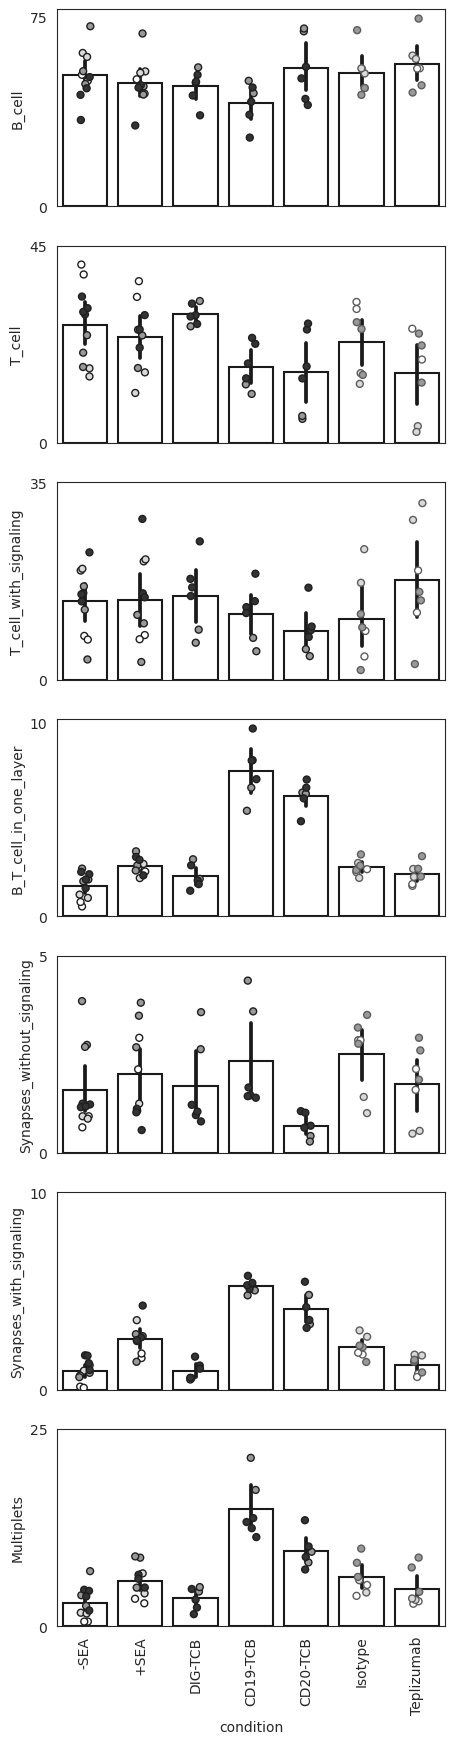

In [17]:

sns.set_style("white")
fig, ax = plt.subplots(ncols = 1, nrows = 7  ,figsize = (5,3*7), sharex = True)

for i, cl in enumerate(["B_cell",
           "T_cell",
           "T_cell_with_signaling",
           "B_T_cell_in_one_layer",
           "Synapses_without_signaling",
           "Synapses_with_signaling",
           "Multiplets"]):
    ax[i] = sns.stripplot(data = metadata_alive , 
                       x = "condition",
                       y = cl, 
                       hue = "experiment", 
                       order =[ '-SEA',
                            '+SEA',
                            'DIG-TCB', 
                            'CD19-TCB',
                            'CD20-TCB',
                            'Isotype',
                            'Teplizumab'],
                       hue_order = [
                                    "Experiment_1",
                                    "Experiment_2",
                                    "Experiment_3",
                                    "Experiment_4"],
                       s = 5,
                       linewidth=1,
                       #split = True,
                      palette=np.array([(1,1,1 ),
                                        (0.85, 0.85, 0.85 ),
                                        (0.60, 0.60, 0.60 ),
                                        (0.2,0.2,0.2 )]),
                       dodge=False,
                      ax = ax[i]) 


    ax[i] = sns.barplot(data = metadata_alive , 
                       x = "condition",
                       y = cl, 
                       order = [ '-SEA',
                            '+SEA',
                            'DIG-TCB', 
                            'CD19-TCB',
                            'CD20-TCB',
                            'Isotype',
                            'Teplizumab'], 
                     linewidth=1.5, facecolor=(1, 1, 1, 0),
                     errcolor=".1", edgecolor=".1",
                ax=ax[i]) 
    ax[i].legend().remove()
    ax[i].set_xticklabels([])
    rr = int(metadata_alive[cl].max())%5
    upper_bound = int(metadata_alive[cl].max()) - rr + 5
    ax[i].set_yticks([0, upper_bound]   )

###

ax[6].set_xticklabels([ '-SEA',
                            '+SEA',
                            'DIG-TCB', 
                            'CD19-TCB',
                            'CD20-TCB',
                            'Isotype',
                            'Teplizumab'
                      ], rotation = "vertical")

plt.savefig('Supplementary Figure - class frequencies per condition.svg', bbox_inches="tight")
plt.savefig('Supplementary Figure - class frequencies per condition.png', bbox_inches="tight")

In [18]:
metadata_alive

,donor,experiment,condition,T_cell,T_cell_with_signaling,B_T_cell_in_one_layer,Synapses_without_signaling,Synapses_with_signaling,Multiplets,B_cell,key
0,Donor_1,Experiment_1,+SEA,36.94,7.92,2.53,2.92,1.6,3.48,44.62,Experiment_1 Donor_1
1,Donor_1,Experiment_1,-SEA,40.73,7.77,0.51,0.65,0.15,0.59,49.62,Experiment_1 Donor_1
2,Donor_1,Experiment_1,Isotype,32.2,8.65,2.43,2.86,1.78,5.23,46.84,Experiment_1 Donor_1
3,Donor_1,Experiment_1,Teplizumab,26.09,11.92,1.57,2.13,0.8,2.85,54.64,Experiment_1 Donor_1
7,Donor_2,Experiment_1,+SEA,33.35,7.18,2.31,2.12,1.83,2.91,50.29,Experiment_1 Donor_2
8,Donor_2,Experiment_1,-SEA,38.47,7.12,0.74,0.93,0.09,0.59,52.04,Experiment_1 Donor_2
9,Donor_2,Experiment_1,Isotype,30.6,4.12,2.28,2.86,1.87,3.85,54.42,Experiment_1 Donor_2
10,Donor_2,Experiment_1,Teplizumab,19.06,19.38,1.66,1.6,0.64,3.16,54.51,Experiment_1 Donor_2
77,Donor_3,Experiment_2,+SEA,11.43,21.0,2.7,1.25,3.52,6.7,53.40,Experiment_2 Donor_3
78,Donor_3,Experiment_2,-SEA,15.2,19.37,1.12,0.93,0.96,1.71,60.70,Experiment_2 Donor_3


We compare the Isotype vs Teplizumab and DIG-TCB vs CD19-TCB. In the main text, DIG-TCB is mentioned as Ctrl-TCB. First, we calculate the fold change of every donor, experiment and condition

In [19]:
metadata_alive_melted_difference = pd.DataFrame(columns=[ "experiment",
                                                         "donor",
                                                         "condition_1", 
                                                         "condition_2",  
                                                         "class",
                                                         "value_1",
                                                         "value_2", 
                                                         "fold_change"])

possible_comparison = [
    ("Isotype", "Teplizumab"),
    ("DIG-TCB", "CD19-TCB"),
]


for exp in metadata_alive.experiment.unique():
    for don in metadata_alive.donor.unique():
        indx = metadata_alive.experiment == exp
        indx = indx & (metadata_alive.donor == don)
        for cond1, cond2 in possible_comparison:
            indx1 = indx & (metadata_alive.condition == cond1)
            indx2 = indx & (metadata_alive.condition == cond2)
            if indx1.sum()*indx2.sum()>0:
                print(cond1, indx1.sum())
                print(cond2, indx2.sum())
                for col in ["T_cell",
                            "T_cell_with_signaling",
                            "B_T_cell_in_one_layer",
                            "Synapses_without_signaling",
                            "Synapses_with_signaling",
                            "Multiplets",
                            "B_cell"]:
                    results = {
                    "experiment":exp,
                    "donor":don,
                    "condition_1":cond1,
                    "condition_2":cond2,
                     }
                    results["class"] = col
                    results["value_1"] = metadata_alive.loc[indx1,col].to_numpy()[0]
                    results["value_2"] = metadata_alive.loc[indx2,col].to_numpy()[0]
                    fold_change = results["value_2"] / (results["value_1"] + 1e-16)
                    results["fold_change"] = np.log2(fold_change)

                    results = pd.DataFrame(results, index=[0])      
                    metadata_alive_melted_difference = pd.concat([metadata_alive_melted_difference, results]).reset_index(drop=True)


Isotype 1
Teplizumab 1
Isotype 1
Teplizumab 1
Isotype 1
Teplizumab 1
Isotype 1
Teplizumab 1
Isotype 1
Teplizumab 1
DIG-TCB 1
CD19-TCB 1
Isotype 1
Teplizumab 1
DIG-TCB 1
CD19-TCB 1
Isotype 1
Teplizumab 1
DIG-TCB 1
CD19-TCB 1
DIG-TCB 1
CD19-TCB 1
DIG-TCB 1
CD19-TCB 1
DIG-TCB 1
CD19-TCB 1


In [20]:
metadata_alive_melted_difference["key"] = metadata_alive_melted_difference["experiment"] + " " +  metadata_alive_melted_difference["donor"] 

In [21]:
metadata_alive_melted_difference.columns

Index(['experiment', 'donor', 'condition_1', 'condition_2', 'class', 'value_1',
       'value_2', 'fold_change', 'key'],
      dtype='object')

In [22]:
cols = ['condition_1', 'condition_2', 'class', 'fold_change']

metadata_alive_melted_difference.loc[:,cols].groupby(["condition_1","condition_2","class"]).median()["fold_change"]

condition_1  condition_2  class                     
DIG-TCB      CD19-TCB     B_T_cell_in_one_layer         1.985236
                          B_cell                       -0.210612
                          Multiplets                    2.039676
                          Synapses_with_signaling       2.733999
                          Synapses_without_signaling    0.594125
                          T_cell                       -0.774076
                          T_cell_with_signaling        -0.427464
Isotype      Teplizumab   B_T_cell_in_one_layer        -0.172550
                          B_cell                        0.091608
                          Multiplets                   -0.401418
                          Synapses_with_signaling      -0.686340
                          Synapses_without_signaling   -0.574583
                          T_cell                       -0.303564
                          T_cell_with_signaling         0.701089
Name: fold_change, dtype: float64

In [23]:
cols = ['condition_1', 'condition_2', 'class', 'fold_change']

metadata_alive_melted_difference.loc[:,cols].groupby(["condition_1","condition_2","class"]).mean()["fold_change"]

condition_1  condition_2  class                     
DIG-TCB      CD19-TCB     B_T_cell_in_one_layer         1.894166
                          B_cell                       -0.225552
                          Multiplets                    2.144020
                          Synapses_with_signaling       2.614835
                          Synapses_without_signaling    0.508805
                          T_cell                       -0.807253
                          T_cell_with_signaling        -0.342923
Isotype      Teplizumab   B_T_cell_in_one_layer        -0.224644
                          B_cell                        0.093730
                          Multiplets                   -0.436227
                          Synapses_with_signaling      -0.848665
                          Synapses_without_signaling   -0.682212
                          T_cell                       -0.854882
                          T_cell_with_signaling         0.796376
Name: fold_change, dtype: float64

# Statisctial tests

In [24]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

metadata_alive_wilcoxon_rank = pd.DataFrame(columns=[ 'B_cell',
                                                     'T_cell',
                                                     'T_cell_with_signaling',
                                                     'B_T_cell_in_one_layer',
                                                     'Synapses_without_signaling',
                                                     'Synapses_with_signaling', 
                                                     'Multiplets'])


for cond1, cond2 in possible_comparison:
    print(cond1, cond2)
    
    results =  dict()
    for col in [ 'B_cell',
                'T_cell',
                'T_cell_with_signaling',
                'B_T_cell_in_one_layer',
                'Synapses_without_signaling',
                'Synapses_with_signaling', 
                'Multiplets']:
    
        indx = metadata_alive_melted_difference.condition_1 == cond1
        indx = indx & (metadata_alive_melted_difference.condition_2 == cond2)
        indx = indx & (metadata_alive_melted_difference["class"] == col)
        
        fold_change = metadata_alive_melted_difference.loc[indx,"value_2"].to_numpy() / metadata_alive_melted_difference.loc[indx,"value_1"].to_numpy()
        fold_change = np.log2(fold_change)
        results[col] = stats.wilcoxon(fold_change).pvalue

    results = pd.DataFrame(results,index=[0])
    metadata_alive_wilcoxon_rank = pd.concat([metadata_alive_wilcoxon_rank, results]).reset_index(drop=True)

    
metadata_alive_wilcoxon_rank.index = possible_comparison

Isotype Teplizumab
DIG-TCB CD19-TCB


In [25]:
metadata_alive_wilcoxon_rank

,B_cell,T_cell,T_cell_with_signaling,B_T_cell_in_one_layer,Synapses_without_signaling,Synapses_with_signaling,Multiplets
"(Isotype, Teplizumab)",0.015625,0.015625,0.015625,0.109375,0.015625,0.015625,0.03125
"(DIG-TCB, CD19-TCB)",0.031250,0.031250,0.093750,0.031250,0.031250,0.031250,0.03125


Multi testing correction

In [26]:
for i in range(len(metadata_alive_wilcoxon_rank)):
    metadata_alive_wilcoxon_rank.iloc[i,:] = multipletests(metadata_alive_wilcoxon_rank.iloc[i,:],alpha=0.05 ,method='fdr_bh')[1]

metadata_alive_wilcoxon_rank = metadata_alive_wilcoxon_rank.astype(float) 

# Heatmap of the p-values

<Axes: >

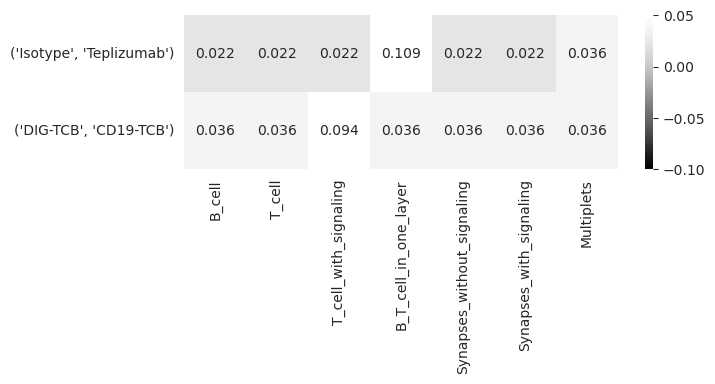

In [27]:
fig, ax = plt.subplots(figsize = (7,2))
sns.heatmap(metadata_alive_wilcoxon_rank, 
            cmap = "Greys_r", 
            annot=True, 
            fmt=".3f", 
            vmin = 0.05, 
            vmax = 0.0) # 

# Frequency difference of antibodies

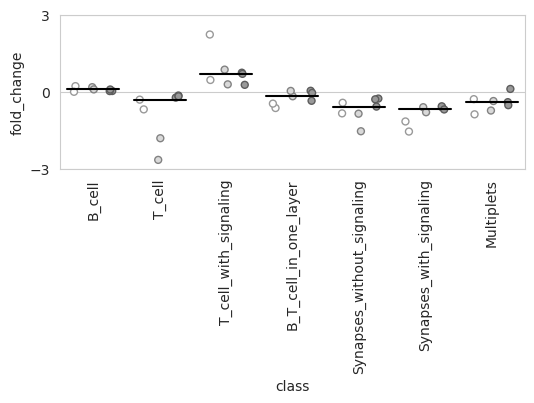

In [28]:
  
    
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6,2))
indx = metadata_alive_melted_difference["condition_1"] == "Isotype"
indx = indx & (metadata_alive_melted_difference["condition_2"] == "Teplizumab")
ax = sns.stripplot(data = metadata_alive_melted_difference.loc[indx,:], 
                   x = "class",
                   y = "fold_change", 
                   hue = "experiment", 
                   order = [ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'],
                   hue_order = ["Experiment_1",
                                "Experiment_2",
                                "Experiment_3"],
                   s = 5,
                   linewidth=1,
                  palette=np.array([(1,1,1 ),
                   					(0.85, 0.85, 0.85 ),
                   					(0.60, 0.60, 0.60 ),
                   					(0.2,0.2,0.2 )]),
                   dodge=True,
                  ax = ax)

ax = sns.boxplot(
            data=metadata_alive_melted_difference.loc[indx,:],
            whiskerprops={'visible': False},
            zorder=10,
            x = "class",
            y = "fold_change", 
            hue = "condition_2", 
            order = [ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'],
            hue_order = ["Teplizumab"],
            palette=["black"],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.set_yticks([-3,0,3])
ax.legend().remove()
ax.set_xticklabels([ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'], rotation = "vertical")

plt.savefig('Figure - fold changes Isotype vs. Teplizumab.svg', bbox_inches="tight")
plt.savefig('Figure - fold changes Isotype vs. Teplizumab.png', bbox_inches="tight")

In [29]:
metadata_alive_melted_difference.loc[indx,:].to_csv("Source Data Figure 2e.csv", index=False)

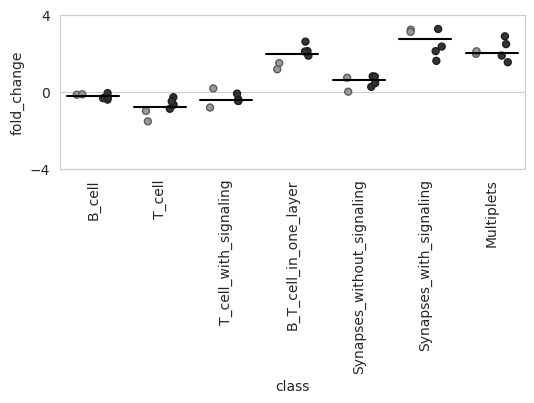

In [30]:
 
    
    
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6,2))
indx = metadata_alive_melted_difference["condition_1"] == "DIG-TCB"
indx = indx & (metadata_alive_melted_difference["condition_2"] == "CD19-TCB")
ax = sns.stripplot(data = metadata_alive_melted_difference.loc[indx,:], 
                   x = "class",
                   y = "fold_change", 
                   hue = "experiment", 
                   order = [ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'],
                   hue_order = [
                                "Experiment_3",
                                "Experiment_4"],
                   s = 5,
                   linewidth=1,
                  palette=np.array([
                   					(0.60, 0.60, 0.60 ),
                   					(0.2,0.2,0.2 )]),
                   dodge=True,
                  ax = ax)

ax = sns.boxplot(
            data=metadata_alive_melted_difference.loc[indx,:],
            whiskerprops={'visible': False},
            zorder=10,
            x = "class",
            y = "fold_change", 
            hue = "condition_2", 
            order = [ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'],
            hue_order = ["CD19-TCB"],
            palette=["black"],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
ax.set_yticks([-4,0,4])
ax.legend().remove()
ax.set_xticklabels([ 'B_cell',
                            'T_cell',
                            'T_cell_with_signaling',
                            'B_T_cell_in_one_layer',
                            'Synapses_without_signaling',
                            'Synapses_with_signaling', 
                            'Multiplets'], rotation = "vertical")

plt.savefig('1 - fold changes DIG-TCB vs. CD19-TCB.svg', bbox_inches="tight")
plt.savefig('1 - fold changes DIG-TCB vs. CD19-TCB.png', bbox_inches="tight")

In [31]:
metadata_alive_melted_difference.loc[indx,:].to_csv("Source Data Figure 2f.csv", index=False)

In [32]:
#metadata_alive.to_csv("/pstore/data/DS4/synapse_data_features/metadata_alive_with_predictions.csv", index = False)